In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

In [2]:
matplotlib.rc('animation', html='html5')
%matplotlib inline

In [5]:
from numpy import sin, cos

class Arm3DOF(object):
    """ 3 DOF Arm class
    init_state :: [theta1, theta2, theta3] in radians,
        where theta1, theta2, theta3 is the angle of the links 1, 2, 3 respectively
    L1, L2, L3 :: the length of the links 1, 2, 3respectively
    origin     :: the origin of the arm
    """
    def __init__(self,
                 init_state=[0., 0., 0.],
                 L1=1.,
                 L2=1.,
                 L3=1.,
                 origin=(0., 0.)):
        self.init_state = np.asarray(init_state, dtype='float')
        self.params     = (L1, L2, L3)
        self.origin     = origin
        self.state      = self.init_state
        
    def position(self):
        """compute the x, y position of the joints"""
        L1, L2, L3 = self.params
        x = np.cumsum([self.origin[0],
                       L1 * np.cos(self.state[0]),
                       L2 * np.cos(self.state[0] + self.state[1]),
                       L3 * np.cos(self.state[0] + self.state[1] + self.state[2])])
        y = np.cumsum([self.origin[1],
                       L1 * np.sin(self.state[0]),
                       L2 * np.sin(self.state[0] + self.state[1]),
                       L3 * np.sin(self.state[0] + self.state[1] + self.state[2])])
        return (x, y)
    
    def ee(self):
        """return the position of the end-effector"""
        x, y = self.position()
        ee_x, ee_y = x[-1], y[-1]
        return ee_x, ee_y
    
    def update(self, dt, Xdot):
        """update the position of the arm given the dt and Xdot
        dt   :: time step
        Xdot :: the cartesian rates
        """
        dstate = np.dot(np.linalg.pinv(arm.Jacobian()), Xdot).reshape(-1) 
        self.state += dstate * dt
    
    def Jacobian(self):
        """compute the jacobian of the arm"""
        q1, q2, q3 = self.state
        L1, L2, L3 = self.params
        s1   = sin(q1)
        c1   = cos(q1)
        s12  = sin(q1 + q2)
        c12  = cos(q1 + q2)
        s123 = sin(q1 + q2 + q3)
        c123 = cos(q1 + q2 + q3)
        
        return np.array([[-L1 * s1 - L2 * s12 - L3 * s123, -L2 * s12 - L3 * s123, -L3 * s123],
                         [ L1 * c1 + L2 * c12 + L3 * c123,  L2 * c12 + L3 * c123,  L3 * c123],
                         [                              1,                     1,          1]])
        

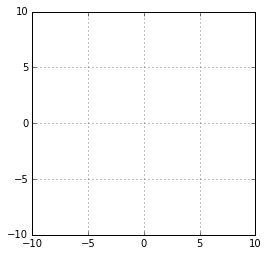

In [21]:
# set up figure and animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-10, 10), ylim=(-10, 10))
ax.grid()
line, = ax.plot([], [], 'o-', lw=2)

In [22]:
dt = 1./10 # 10 fps
interval = 1000 * dt
Xdot = np.array([[0.2],
                 [-.3],
                 [-.2]])
# Xdot = np.array([[0.2],
#                  [0. ],
#                  [0. ]])

#init_state = np.random.randn(3) * 0.1

init_state = np.deg2rad(np.array([10, 20, 30]))

arm = Arm3DOF(init_state=init_state, L1=4, L2=3, L3=2)

#soln = (arm.state).reshape(1, -1)

In [23]:
def init():
    """initialize animation"""
    line.set_data(*arm.position())
    return line,

In [24]:
def animate(i):
    """perform animation step"""
    global arm, dt, Xdot, soln
    arm.update(dt, Xdot)
    #soln = np.vstack((soln, (arm.state).reshape(1, -1)))
    line.set_data(*arm.position())    
    return line, 

In [25]:
simulate = animation.FuncAnimation(fig, animate, frames=50,
                              interval=interval, blit=True, init_func=init)

In [26]:
simulate